In [2]:
from utils import load_and_prepare_building_dfs, get_voll_temps, normalize_building_dfs, get_validation_data
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from kneed import KneeLocator
import random
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
building_dfs = load_and_prepare_building_dfs(esave_path="data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls", vis_path='data/VIS Målere.xlsx')
temp = get_voll_temps(voll_path='data/Volltemp.xlsx')
anomalies_gt = get_validation_data(validation_data='data/validationdata.xlsx')

for building_name, building_df in list(building_dfs.items()):
    building_dfs[building_name] = building_df.resample('D').sum()
    if building_df.isnull().values.any():
        building_dfs.pop(building_name)

    elif building_df.isna().values.any():
        building_dfs.pop(building_name)

print(len(building_dfs))

daily_temp = temp.resample('D').mean()['Eklima_68860_TAM']

# only used for visualizing and mse comparrisons. can be moved to get_mse for orchest
# building_dfs = normalize_building_dfs(building_dfs, method='min-max')

Number of rows: 43848
Number of columns: 700
Number of buildings: 232
Data loaded in 87.58402633666992 seconds
172


In [4]:
def get_precision_recall(anomalies_gt, anomalies_pred):
    # each argument is a list of tuples
    # if the tuple exists in gt and pred its a true positive
    # if the tuple exists in gt but not in pred its a false negative
    # if the tuple exists in pred but not in gt its a false positive

    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for gt_tuple in anomalies_gt:
        if gt_tuple in anomalies_pred:
            true_positives += 1
        else:
            false_negatives += 1

    for pred_tuple in anomalies_pred:
        if pred_tuple not in anomalies_gt:
            false_positives += 1

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return precision, recall

In [5]:
def linear_interpolation(x, x0, y0, x1, y1):
    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class ET:
    def __init__(self, dx, dy):
        self.dx = dx
        self.dy = dy
        self.threshold = None
        self.esave = False

    def expected(self, temperature):
        if temperature < self.dx[0]:
            return linear_interpolation(temperature, self.dx[0], self.dy[0], self.dx[1], self.dy[1])
        if temperature > self.dx[-1]:
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])
    
    def get_expected_series(self, temperature_series):
        return temperature_series.apply(self.expected)
    
    def get_proportial_series(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return energy_series / expected_series

    def get_anomolies_series(self, energy_series, temperature_series):
        if self.threshold is None:
            raise Exception("Threshold not set. Use set_threshold()")
        expected_series = self.get_expected_series(temperature_series)
        if not self.esave:
            mask = (energy_series - expected_series).abs() >= self.threshold
        else:
            # mask if ratio is greater than threshold
            mask = ((energy_series / expected_series).abs() >= 1+ self.threshold) | (energy_series - expected_series > 1000)
            
        return energy_series[mask]

    def get_mse(self, energy_series, temperature_series):
        expected_series = self.get_expected_series(temperature_series)
        return ((energy_series - expected_series) ** 2).mean()

    def get_top_diffs(self, energy_series, temperature_series, n):
        expected_series = self.get_expected_series(temperature_series)
        diffs = (energy_series - expected_series).abs()
        # sort diffs in descending order
        sorted_diffs = diffs.sort_values(ascending=False)
        # get the top n values
        top_n = sorted_diffs[:n]
        return top_n

    def plot(self, energy_series, temperature_series):
        plt.plot(self.dx, self.dy, color='red', linewidth=4)

        # if threshold is set, find anomalies and color them in the scatter plot
        plt.scatter(temperature_series, energy_series, color='blue')
        if self.threshold is not None:
            anomalies = self.get_anomolies_series(energy_series, temperature_series)
            plt.scatter(temperature_series[anomalies.index], energy_series[anomalies.index], color='red', s=100)
            # plot one curve over and under the expected curve
            sorted_temperature_series = temperature_series.sort_values()
            plt.plot(sorted_temperature_series, self.get_expected_series(sorted_temperature_series) + self.threshold, color='green', linewidth=3)
            plt.plot(sorted_temperature_series, self.get_expected_series(sorted_temperature_series) - self.threshold, color='green', linewidth=3)
            plt.xlim(-10, 20)
            # plt.ylim(-0.1, 1.1)
            plt.title("Threshold: " + str(round(self.threshold, 2)) + " Lines: " + str(len(self.dx)))
            
        plt.show()

    def set_threshold(self, threshold):
        self.threshold = threshold

# Evaluation of Esave

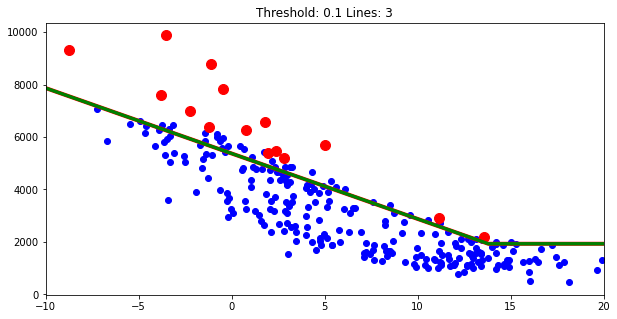

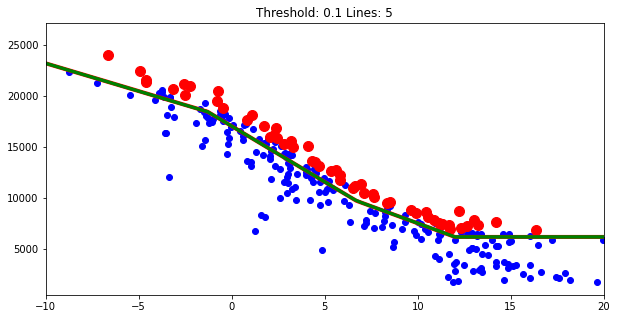

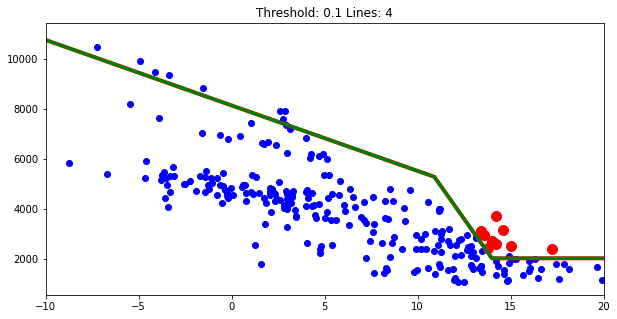

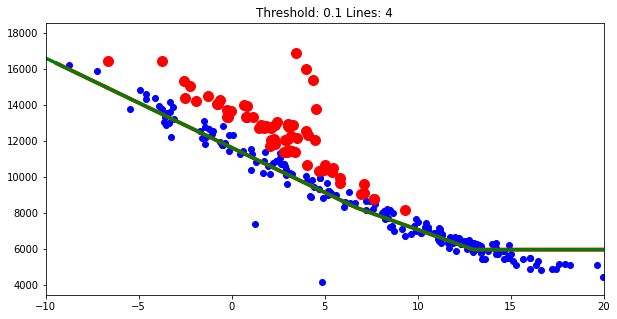

Precision: 0.04827586206896552
Recall: 0.2916666666666667


In [6]:
validation_buildings = ['Trondheim Kommune - Aastahagen barnehage', 'Trondheim Kommune - Charlottenlund ungdomsskole', 'Trondheim Kommune - Dalgård Idrettsanlegg', 'Trondheim Kommune - Kystad sykehjem']
# from ET kurver excel file
esave_curves = {validation_buildings[0]: ([-12.6, 13.8, 20], [8518, 1930, 1930]),
                validation_buildings[1]: ([-14.5, -1.3, 6.7, 12, 30], [25623, 18445, 9726, 6188, 6188]),
                validation_buildings[2]: ([-10.7, 10.9, 14, 20], [10951, 5288, 2025, 2025]),
                validation_buildings[3]: ([-9.4, 6.7, 13, 20], [16320, 8291, 5953, 5953])}

anomalies_pred = []
for building_name in validation_buildings:
    # create ET curve for all validation buildings
    dx, dy = esave_curves[building_name]
    esave_ET = ET(dx=dx, dy=dy)
    esave_ET.threshold = 0.1
    esave_ET.esave = True
    validation_energy = building_dfs[building_name]['Totalt']
    # validation_energy to weekly
    validation_energy = validation_energy.resample('W').sum()
    # temperature to weekly
    weekly_temperature = daily_temp.resample('W').mean()
    
    # find anomalies
    anomalies = esave_ET.get_anomolies_series(validation_energy, weekly_temperature)
    # plot the curve
    esave_ET.plot(validation_energy, weekly_temperature)
    # find week and year of each anomaly
    for anomaly in anomalies.index:
        week = anomaly.week
        year = anomaly.year
        anomalies_pred.append((building_name, year, week))

# calculate precision and recall
precision, recall = get_precision_recall(anomalies_gt, anomalies_pred)
print("Precision: " + str(precision))
print("Recall: " + str(recall))


# Evaluation of automatic ET

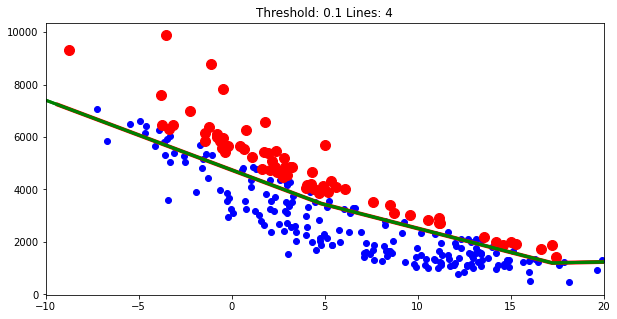

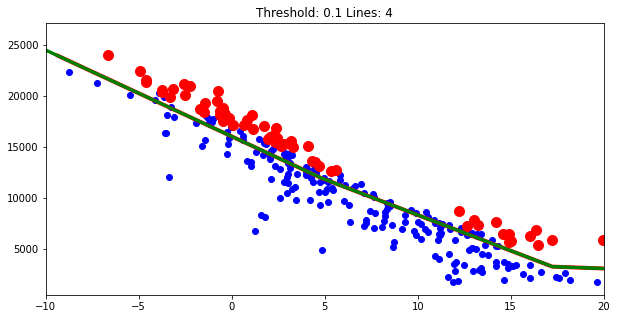

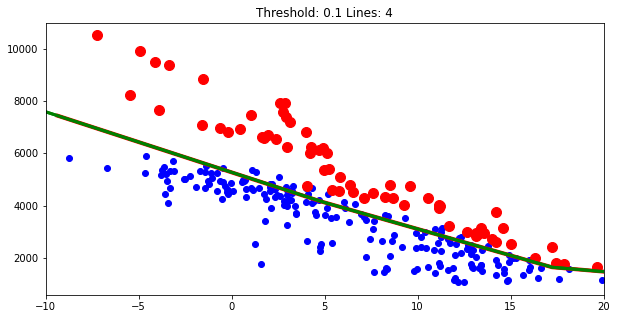

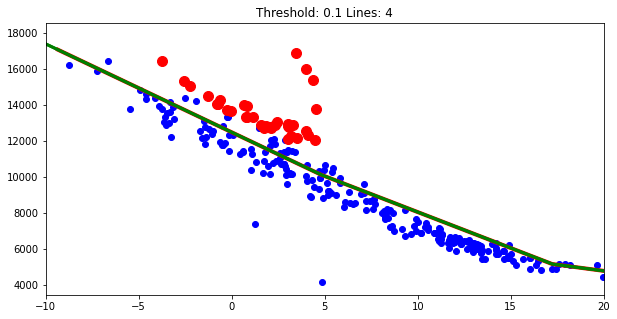

Precision: 0.03070175438596491
Recall: 0.2916666666666667


In [7]:
validation_buildings = ['Trondheim Kommune - Aastahagen barnehage', 'Trondheim Kommune - Charlottenlund ungdomsskole', 'Trondheim Kommune - Dalgård Idrettsanlegg', 'Trondheim Kommune - Kystad sykehjem']
# from ET kurver excel file
et_curves = {validation_buildings[0]: ([-9.34, 4.81, 17.23, 22.99] , [7231.79, 3463.93, 1197.85, 1279.33]),
                validation_buildings[1]: ([-9.34, 4.81, 17.23, 22.99] , [23913.63, 11960.89, 3282.66, 2902.79]),
                validation_buildings[2]: ([-9.34, 4.81, 17.23, 22.99] , [7429.6, 4153.89, 1640.08, 1292.75]),
                validation_buildings[3]: ([-9.34, 4.81, 17.23, 22.99] , [17083.79, 10121.74, 5150.93, 4359.96])}

anomalies_pred = []
for building_name in validation_buildings:
    # create ET curve for all validation buildings
    dx, dy = et_curves[building_name]
    esave_ET = ET(dx=dx, dy=dy)
    esave_ET.threshold = 0.1
    esave_ET.esave = True # not esave, but we want to use additative threshold
    validation_energy = building_dfs[building_name]['Totalt']
    # validation_energy to weekly
    validation_energy = validation_energy.resample('W').sum()
    # temperature to weekly
    weekly_temperature = daily_temp.resample('W').mean()
    
    # find anomalies
    anomalies = esave_ET.get_anomolies_series(validation_energy, weekly_temperature)
    # plot the curve
    esave_ET.plot(validation_energy, weekly_temperature)
    # find week and year of each anomaly
    for anomaly in anomalies.index:
        week = anomaly.week
        year = anomaly.year
        anomalies_pred.append((building_name, year, week))

# calculate precision and recall
precision, recall = get_precision_recall(anomalies_gt, anomalies_pred)
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# evaluation of daily ET

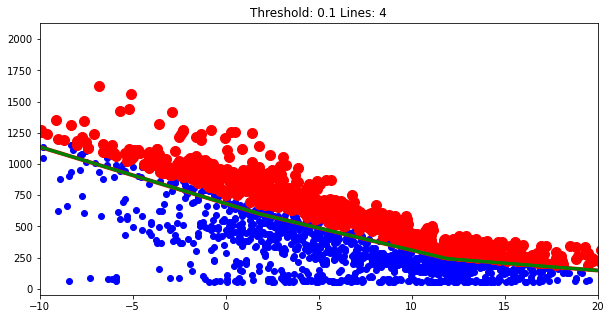

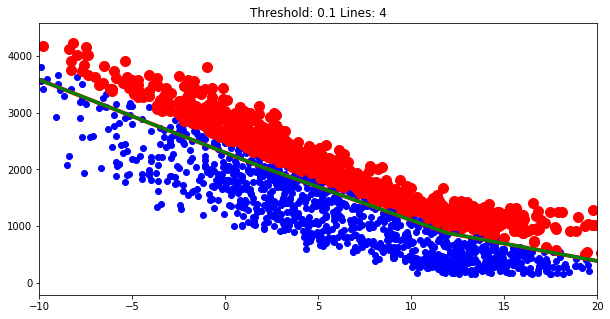

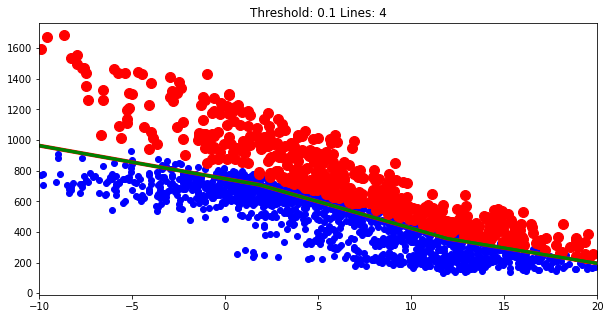

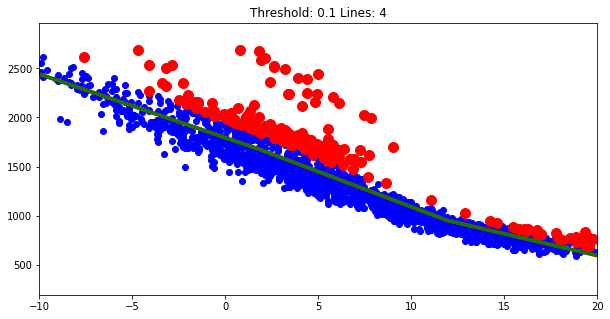

Precision: 0.026984126984126985
Recall: 0.7083333333333334


In [8]:
validation_buildings = ['Trondheim Kommune - Aastahagen barnehage', 'Trondheim Kommune - Charlottenlund ungdomsskole', 'Trondheim Kommune - Dalgård Idrettsanlegg', 'Trondheim Kommune - Kystad sykehjem']
# from ET kurver excel file
et_curves = {validation_buildings[0]: ([-16.1, 1.8, 11.91, 26.18] , [1414.81, 600.74, 241.35, 74.31]),
                validation_buildings[1]: ([-16.1, 1.8, 11.91, 26.18] , [4369.26, 2065.32, 881.01, 5.08]),
                validation_buildings[2]: ([-16.1, 1.8, 11.91, 26.18] , [1095.31, 708.95, 357.84, 70.66]),
                validation_buildings[3]: ([-16.1, 1.8, 11.91, 26.18] , [2835.74, 1677.18, 952.13, 319.45])}

anomalies_pred = []
for building_name in validation_buildings:
    # create ET curve for all validation buildings
    dx, dy = et_curves[building_name]
    esave_ET = ET(dx=dx, dy=dy)
    esave_ET.threshold = 0.1
    esave_ET.esave = True # not esave, but we want to use additative threshold
    validation_energy = building_dfs[building_name]['Totalt']

    # find anomalies
    anomalies = esave_ET.get_anomolies_series(validation_energy, daily_temp)
    # plot the curve
    esave_ET.plot(validation_energy, daily_temp)
    # find week and year of each anomaly
    for anomaly in anomalies.index:
        week = anomaly.week
        year = anomaly.year
        anomalies_pred.append((building_name, year, week))

    # remove duplcate tuples in anomalies_pred
    anomalies_pred = list(set(anomalies_pred))

# calculate precision and recall
precision, recall = get_precision_recall(anomalies_gt, anomalies_pred)
print("Precision: " + str(precision))
print("Recall: " + str(recall))